<a href="https://colab.research.google.com/github/sdesena/sicar-integration/blob/main/02_CAR_e_indices_de_vegetacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SICAR x INDEX VEGETATION

* O objetivo deste material é permitir a utilização das bases do SICAR para extração de dados de séries temporais de índices de vegetação, bem como plotar multiplas imagens.

In [2]:
##import mapclassify
!pip install mapclassify -q

In [3]:
##Vamos importar as bibliotecas
import geemap
import ee
import eerepr
import geopandas as gpd
import mapclassify
import folium
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
##Abrir nossa base de dados
gdf_res = gpd.read_file('/content/drive/MyDrive/SICAR/shapefiles/SP_RESERVA_LEGAL/RESERVA_LEGAL_1.shp')
# # Arredondar a coluna NUM_AREA para duas casas decimais
gdf_res['num_area'] = gdf_res['num_area'].round(2)
gdf_res.head()

,cod_tema,nom_tema,cod_imovel,num_area,ind_status,des_condic,geometry
0,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500402-A79BCD74BF1444239F4AF6A7D5E00568,0.91,AT,Aguardando analise,"MULTIPOLYGON (((-46.70191 -21.84815, -46.70190..."
1,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500402-572AE6F74E72497A9D2A3351BD7B6CDE,6.71,AT,"Analisado, aguardando atendimento a notificacao","MULTIPOLYGON (((-46.71701 -21.84113, -46.71638..."
2,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500402-EE5A8D1E342C401C896AC8F07AB4B7CB,2.58,AT,"Aguardando analise, apos revisao ou atendiment...","MULTIPOLYGON (((-46.70915 -21.87148, -46.70944..."
3,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500402-8E4D12ABCECC4DF3B4C7367CF9F233A4,3.24,AT,"Analisado, aguardando atendimento a notificacao","MULTIPOLYGON (((-46.70907 -21.86099, -46.70955..."
4,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500402-0A03E853F57046E0B172302C69128786,2.21,AT,"Analisado, aguardando atendimento a notificacao","MULTIPOLYGON (((-46.71904 -21.88057, -46.71955..."


In [6]:
##Lendo dados da coluna
gdf_res['nom_tema'].unique()

array(['Reserva Legal Proposta', 'Reserva Legal Averbada',
       'Reserva Legal Aprovada e nao Averbada'], dtype=object)

In [7]:
gdf_imovel = gpd.read_file('/content/drive/MyDrive/SICAR/shapefiles/SP_AREA_IMOVEL/AREA_IMOVEL_1.shp')
gdf_imovel.head()

,cod_tema,nom_tema,cod_imovel,mod_fiscal,num_area,ind_status,ind_tipo,des_condic,municipio,cod_estado,geometry
0,AREA_IMOVEL,Area do Imovel,SP-3500402-A79BCD74BF1444239F4AF6A7D5E00568,0.2922,6.4292,AT,IRU,Aguardando analise,Aguas da Prata,SP,"POLYGON ((-46.70278 -21.84692, -46.70260 -21.8..."
1,AREA_IMOVEL,Area do Imovel,SP-3500402-572AE6F74E72497A9D2A3351BD7B6CDE,2.1660,47.6521,AT,IRU,"Analisado, aguardando atendimento a notificacao",Aguas da Prata,SP,"POLYGON ((-46.72991 -21.84529, -46.72850 -21.8..."
2,AREA_IMOVEL,Area do Imovel,SP-3500402-EE5A8D1E342C401C896AC8F07AB4B7CB,0.3501,7.7025,AT,IRU,"Aguardando analise, apos revisao ou atendiment...",Aguas da Prata,SP,"POLYGON ((-46.71048 -21.87365, -46.71058 -21.8..."
3,AREA_IMOVEL,Area do Imovel,SP-3500402-8E4D12ABCECC4DF3B4C7367CF9F233A4,1.1161,24.5551,AT,IRU,"Analisado, aguardando atendimento a notificacao",Aguas da Prata,SP,"POLYGON ((-46.70497 -21.86396, -46.70663 -21.8..."
4,AREA_IMOVEL,Area do Imovel,SP-3500402-0A03E853F57046E0B172302C69128786,0.8009,17.6187,AT,IRU,"Analisado, aguardando atendimento a notificacao",Aguas da Prata,SP,"POLYGON ((-46.71971 -21.88068, -46.71969 -21.8..."


In [8]:
gdf_imovel_status = gdf_imovel.loc[gdf_imovel['ind_status'] == 'PE']

In [9]:
from folium.plugins import MarkerCluster

# Carregar dados shapefile
gdf_imovel_status

# Simplificar geometria para reduzir o consumo de memória
gdf_imovel_status['geometry'] = gdf_imovel_status['geometry'].simplify(tolerance=0.001)

# Preenchendo centróide com lat e long
centroids = gdf_imovel_status.geometry.centroid

# Calcula a média das coordenadas x e y dos centróides
mean_x = centroids.x.mean()
mean_y = centroids.y.mean()

# Cria um mapa base
m = folium.Map(location=[mean_y, mean_x], zoom_start=13)

# Adicionando GeoDataFrame ao mapa usando folium.GeoJson
geojson = folium.GeoJson(
    gdf_imovel_status,
    name="ind_status",
    style_function=lambda feature: {
        'fillColor': 'blue',
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5'
    },
    tooltip=folium.GeoJsonTooltip(fields=['ind_status'], aliases=['Status'])
).add_to(m)

# Adiciona uma camada de satélite do Google
folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
    attr='Google',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

# Adiciona o controle de camadas
folium.LayerControl().add_to(m)

# Exibir o mapa
m


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-9-4860aedc205c>:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf_imovel_status.geometry.centroid


In [12]:
#União dos dados de Reserva Legal e Imovel
joined_gdf = gpd.sjoin(gdf_res,gdf_imovel_status, how='inner', predicate='intersects')
joined_gdf.head()

,cod_tema_left,nom_tema_left,cod_imovel_left,num_area_left,ind_status_left,des_condic_left,geometry,index_right,cod_tema_right,nom_tema_right,cod_imovel_right,mod_fiscal,num_area_right,ind_status_right,ind_tipo,des_condic_right,municipio,cod_estado
451,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,4.90,PE,Aguardando analise,"MULTIPOLYGON (((-49.36990 -22.73287, -49.36943...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP
692,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-3726EB03EAC34A48BEDAF160493C4804,5.74,AT,"Analisado, aguardando atendimento a notificacao","MULTIPOLYGON (((-49.35190 -22.71944, -49.35192...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP
706,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-373F8D621DAB4FAB89B4578B52737AEC,8.45,CA,Cancelado por decisao administrativa,"MULTIPOLYGON (((-49.34010 -22.75386, -49.34011...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP
902,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-37546423CDB44AC096B08D23D74546A2,16.93,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.33778 -22.73102, -49.34030 -22.7...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP
907,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-84D7ED11C56B4436AF18E129E57B18B9,0.66,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.33219 -22.74214, -49.33263 -22.7...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP


In [13]:
# Filtro para um município
joined_gdf = joined_gdf[joined_gdf.municipio=='Agudos']
joined_gdf

,cod_tema_left,nom_tema_left,cod_imovel_left,num_area_left,ind_status_left,des_condic_left,geometry,index_right,cod_tema_right,nom_tema_right,cod_imovel_right,mod_fiscal,num_area_right,ind_status_right,ind_tipo,des_condic_right,municipio,cod_estado
451,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,4.90,PE,Aguardando analise,"MULTIPOLYGON (((-49.36990 -22.73287, -49.36943...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP
692,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-3726EB03EAC34A48BEDAF160493C4804,5.74,AT,"Analisado, aguardando atendimento a notificacao","MULTIPOLYGON (((-49.35190 -22.71944, -49.35192...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP
706,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-373F8D621DAB4FAB89B4578B52737AEC,8.45,CA,Cancelado por decisao administrativa,"MULTIPOLYGON (((-49.34010 -22.75386, -49.34011...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP
902,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-37546423CDB44AC096B08D23D74546A2,16.93,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.33778 -22.73102, -49.34030 -22.7...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP
907,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-84D7ED11C56B4436AF18E129E57B18B9,0.66,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.33219 -22.74214, -49.33263 -22.7...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP
912,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-84D7ED11C56B4436AF18E129E57B18B9,0.01,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.33433 -22.74197, -49.33453 -22.7...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP
916,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-84D7ED11C56B4436AF18E129E57B18B9,0.13,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.33384 -22.74204, -49.33391 -22.7...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP
920,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-84D7ED11C56B4436AF18E129E57B18B9,10.26,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.33301 -22.75352, -49.33303 -22.7...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP
930,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-84D7ED11C56B4436AF18E129E57B18B9,0.56,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.34004 -22.74737, -49.34014 -22.7...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP
933,ARL_PROPOSTA,Reserva Legal Proposta,SP-3500709-84D7ED11C56B4436AF18E129E57B18B9,0.09,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.33538 -22.74203, -49.33504 -22.7...",366,AREA_IMOVEL,Area do Imovel,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,66.5248,798.2971,PE,IRU,Aguardando analise,Agudos,SP


<Axes: >

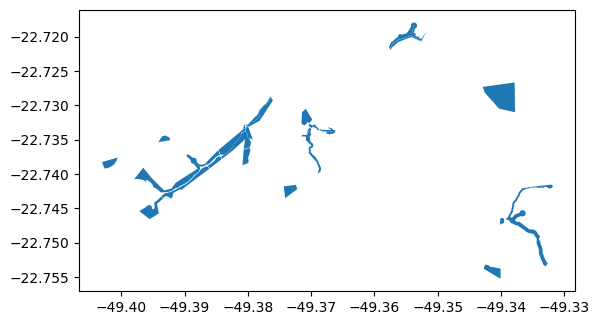

In [14]:
joined_gdf.plot()

##Converter nossa área de estudo para Geojson e usar no GEE

In [15]:
##import json
import json

In [16]:
# Excluir colunas para deixar o arquivo mais leve
joined_gdf.columns

Index(['cod_tema_left', 'nom_tema_left', 'cod_imovel_left', 'num_area_left',
       'ind_status_left', 'des_condic_left', 'geometry', 'index_right',
       'cod_tema_right', 'nom_tema_right', 'cod_imovel_right', 'mod_fiscal',
       'num_area_right', 'ind_status_right', 'ind_tipo', 'des_condic_right',
       'municipio', 'cod_estado'],
      dtype='object')

In [17]:
gdf_gee = joined_gdf.drop(columns=['cod_tema_left','ind_status_right', 'ind_tipo', 'index_right',
       'cod_tema_right', 'nom_tema_right', 'cod_imovel_right', 'mod_fiscal',
       'num_area_right', 'ind_status_right', 'ind_tipo', 'des_condic_right',])
gdf_gee

,nom_tema_left,cod_imovel_left,num_area_left,ind_status_left,des_condic_left,geometry,municipio,cod_estado
451,Reserva Legal Proposta,SP-3500709-E90A4143B7564F748A1CC03E7E90C553,4.90,PE,Aguardando analise,"MULTIPOLYGON (((-49.36990 -22.73287, -49.36943...",Agudos,SP
692,Reserva Legal Proposta,SP-3500709-3726EB03EAC34A48BEDAF160493C4804,5.74,AT,"Analisado, aguardando atendimento a notificacao","MULTIPOLYGON (((-49.35190 -22.71944, -49.35192...",Agudos,SP
706,Reserva Legal Proposta,SP-3500709-373F8D621DAB4FAB89B4578B52737AEC,8.45,CA,Cancelado por decisao administrativa,"MULTIPOLYGON (((-49.34010 -22.75386, -49.34011...",Agudos,SP
902,Reserva Legal Proposta,SP-3500709-37546423CDB44AC096B08D23D74546A2,16.93,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.33778 -22.73102, -49.34030 -22.7...",Agudos,SP
907,Reserva Legal Proposta,SP-3500709-84D7ED11C56B4436AF18E129E57B18B9,0.66,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.33219 -22.74214, -49.33263 -22.7...",Agudos,SP
912,Reserva Legal Proposta,SP-3500709-84D7ED11C56B4436AF18E129E57B18B9,0.01,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.33433 -22.74197, -49.33453 -22.7...",Agudos,SP
916,Reserva Legal Proposta,SP-3500709-84D7ED11C56B4436AF18E129E57B18B9,0.13,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.33384 -22.74204, -49.33391 -22.7...",Agudos,SP
920,Reserva Legal Proposta,SP-3500709-84D7ED11C56B4436AF18E129E57B18B9,10.26,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.33301 -22.75352, -49.33303 -22.7...",Agudos,SP
930,Reserva Legal Proposta,SP-3500709-84D7ED11C56B4436AF18E129E57B18B9,0.56,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.34004 -22.74737, -49.34014 -22.7...",Agudos,SP
933,Reserva Legal Proposta,SP-3500709-84D7ED11C56B4436AF18E129E57B18B9,0.09,AT,"Analisado, aguardando atendimento a notificacao","POLYGON ((-49.33538 -22.74203, -49.33504 -22.7...",Agudos,SP


In [ ]:
# ##convertendo de shp para to json
shp_json = gdf_gee.to_json()
##Carregando o arquivo json
roi = json.loads(shp_json)
##selecionando as features
roi = roi['features']
##Verificando o processo
roi

In [20]:
##Inicializar o GEE
ee.Authenticate()
ee.Initialize(project='ee-sandrosenamachado')

In [21]:
##Definindo filtros na feature
region = ee.FeatureCollection(roi)

In [24]:
# Defina um método para exibir blocos de imagens do Earth Engine em um folium map
##Centralizando a imagem
Map = geemap.Map()
#Para ver uma visualização de satélite do Google como um mapa base
Map.add_basemap('HYBRID')
Map.addLayer(region,{}, 'Reserva legal')
Map.centerObject(region,15)

Map

Map(center=[-22.737196427618695, -49.36633484649305], controls=(WidgetControl(options=['position', 'transparen…

In [26]:
##ponto para seleção da imagem

point = ee.Geometry.Point([-49.35515688534581, -22.71698225635811]);



In [27]:
##Definindo a coleção de imagens
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

##Calculo do índice
def indice(image):
  ndvi = image.normalizedDifference(['B8','B4']).rename('ndvi')
  return image.addBands(ndvi).set({'data':image.date().format('yyyy-MM-dd')})

##Função de nuvens e fator de escala
def maskCloudAndShadowsSR(image):
  cloudProb = image.select('MSK_CLDPRB');
  snowProb = image.select('MSK_SNWPRB');
  cloud = cloudProb.lt(5)
  snow = snowProb.lt(5)
  scl = image.select('SCL')
  shadow = scl.eq(3) # 3 = cloud shadow
  cirrus = scl.eq(10) #10 = cirrus
  #Probabilidade de nuvem inferior a 5% ou classificação de sombra de nuvem
  mask = (cloud.And(snow)).And(cirrus.neq(1)).And(shadow.neq(1));
  return image.updateMask(mask).divide(10000).clip(region)\
      .select("B.*")\
      .copyProperties(image, image.propertyNames())

#Collection
collection=collection.filterBounds(point)\
                     .filterDate('2023-01-01','2024-01-01')\
                     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10))\
                     .map(maskCloudAndShadowsSR)\
                     .map(indice)

print('Coleção', collection.size().getInfo())

Coleção 49


In [28]:
##Add NDVI
Map.addLayer(collection.select('ndvi').first(), {'palette':['red','yellow','green'],'min':0,'max':1},'Ndvi')
Map

Map(bottom=1185058.0, center=[-22.754337678033632, -49.33176598029951], controls=(WidgetControl(options=['posi…

In [29]:
##inserindo as datas
datas = collection.aggregate_array('data').getInfo()
datas

['2023-02-08',
 '2023-03-03',
 '2023-03-18',
 '2023-03-20',
 '2023-03-23',
 '2023-03-30',
 '2023-04-02',
 '2023-04-04',
 '2023-04-24',
 '2023-05-04',
 '2023-05-17',
 '2023-05-19',
 '2023-05-24',
 '2023-06-03',
 '2023-06-06',
 '2023-06-08',
 '2023-06-18',
 '2023-06-21',
 '2023-06-26',
 '2023-06-28',
 '2023-07-06',
 '2023-07-08',
 '2023-07-13',
 '2023-07-21',
 '2023-07-26',
 '2023-08-02',
 '2023-08-05',
 '2023-08-07',
 '2023-08-10',
 '2023-08-17',
 '2023-08-22',
 '2023-08-25',
 '2023-08-30',
 '2023-09-04',
 '2023-09-11',
 '2023-09-16',
 '2023-09-19',
 '2023-09-21',
 '2023-09-24',
 '2023-10-11',
 '2023-10-16',
 '2023-10-21',
 '2023-11-05',
 '2023-11-08',
 '2023-12-08',
 '2023-12-13',
 '2023-12-18',
 '2023-12-20',
 '2023-12-28']

In [30]:
##Criando nome de bandas para série temporal
band_names = [f'ndvi_daily_{str(m).zfill(2)}' for m in datas]
daily_ndvi = ee.Image(collection.select('ndvi').toBands().rename(band_names))
daily_ndvi.bandNames().getInfo()

['ndvi_daily_2023-02-08',
 'ndvi_daily_2023-03-03',
 'ndvi_daily_2023-03-18',
 'ndvi_daily_2023-03-20',
 'ndvi_daily_2023-03-23',
 'ndvi_daily_2023-03-30',
 'ndvi_daily_2023-04-02',
 'ndvi_daily_2023-04-04',
 'ndvi_daily_2023-04-24',
 'ndvi_daily_2023-05-04',
 'ndvi_daily_2023-05-17',
 'ndvi_daily_2023-05-19',
 'ndvi_daily_2023-05-24',
 'ndvi_daily_2023-06-03',
 'ndvi_daily_2023-06-06',
 'ndvi_daily_2023-06-08',
 'ndvi_daily_2023-06-18',
 'ndvi_daily_2023-06-21',
 'ndvi_daily_2023-06-26',
 'ndvi_daily_2023-06-28',
 'ndvi_daily_2023-07-06',
 'ndvi_daily_2023-07-08',
 'ndvi_daily_2023-07-13',
 'ndvi_daily_2023-07-21',
 'ndvi_daily_2023-07-26',
 'ndvi_daily_2023-08-02',
 'ndvi_daily_2023-08-05',
 'ndvi_daily_2023-08-07',
 'ndvi_daily_2023-08-10',
 'ndvi_daily_2023-08-17',
 'ndvi_daily_2023-08-22',
 'ndvi_daily_2023-08-25',
 'ndvi_daily_2023-08-30',
 'ndvi_daily_2023-09-04',
 'ndvi_daily_2023-09-11',
 'ndvi_daily_2023-09-16',
 'ndvi_daily_2023-09-19',
 'ndvi_daily_2023-09-21',
 'ndvi_daily

In [31]:
##Análise estatística por região
stats = daily_ndvi.reduceRegions(
    collection=region,
    reducer=ee.Reducer.mean(),
    scale=10,
    tileScale=4
)

# print(stats.limit(1).getInfo())

In [32]:
##criando um df
stats_df = ee.data.computeFeatures({
    'expression': stats,
    'fileFormat': 'PANDAS_DATAFRAME'
})

# stats_df.head()

In [ ]:
stats_df.to_csv('ndvi.csv')
stats_df.head()

In [ ]:
##Organizando os dados
stats_df = stats_df.melt(
    id_vars=["nom_tema_left"],
    value_vars=band_names,
    var_name="Data",
    value_name="NDVI",
)
stats_df

In [ ]:
# Criar a nova coluna 'Dia' com os últimos 10 caracteres da coluna 'Data'
stats_df['Dia'] = stats_df['Data'].str[-10:]
stats_df

In [ ]:
# Preparar os dados
df_grouped = stats_df.groupby(['Dia', 'nom_tema_left']).mean().reset_index()

# Converter Dia para o tipo datetime para ordenar corretamente
df_grouped['Dia'] = pd.to_datetime(df_grouped['Dia'])

# Criar o gráfico usando Plotly
fig = px.line(df_grouped, x='Dia', y='NDVI', color='nom_tema_left',
              title='Média de NDVI por Dia por Reserva Legal',
              labels={'Dia': 'Dia', 'NDVI': 'Média de NDVI','nom_tema_left': 'Legenda'})

# Ajustar o tamanho do gráfico
fig.update_layout(width=1200, height=700)

# Mostrar o gráfico
fig.show()